# PJM Data Analysis
By Fiona Dean

Kaggle has kindly hosted a large data set including 20 years worth of electrical consumption from the PJM company. The data is presented by Business Unit and has a list of hourly consumption for the timeperiod the Business Unite existed. Since electrical consumption often correlates to temperature and working days, we can find further data sets as follows.

The PJM Data set can be downloaded here: 
    https://www.kaggle.com/robikscube/hourly-energy-consumption
The Daily Temperature of major cities can be downloaded here: 
    https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities
The major US holidays I have compiled from two sources: 
    https://www.public-holidays.us/mobile_US_KF_1998_Federal%20holidays and https://www.timeanddate.com/holidays/us/
To read more about the company, please follow the link: 
    https://www.pjm.com/

# Steps to be completed during import and cleansing:

1. clean up each data set
    This includes checking each file from file from PJM, ensuring that there are no missing hours, and no duplicated hours. If found, the average of the two lines of data surround the situation will be taken and then averaged.
    This also includes finding the dates of all major US holidays.
    
2. combine the data sets into one large pandas dataframe


To set up the environment, we need to import the following libraries. We will also wish to include the datetime library with timedelta, so that we can quickly and accurately assess any cleansing issues in the data. 

In [5]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = (20,5)

To quickly check to see if there are any issues in a PJM file, we can create a function that imports a dataframe, df, and then checks for a duration other than an hour. It can be run with each file after basic processing to make a dataframe and after converting the datetime string into a datetime format. It can also be used to check the final combined dataframe.

In [6]:
def check_df(df):
    print('checking for time related errors...')
    dup = df.duplicated(subset = 'Datetime')
    print(df[dup]) #prints a list of duplicated times from the imported dataframe.
    prev = ''
    for ind, row in df.iterrows():
        now = row[0]
        hour = timedelta(hours = 1)
        duration = now - prev if prev != '' else ''
        if duration != '':
            if duration != hour:
                print('\these values have a duration other than 1 hr', ind)
        prev = now

This function, process_data(filename) can be used with the raw datafile to return a dataframe without time related error. 

First it imports the raw data file, converts the Datetime column to a Datetime format using pd.to_datetime, sorts the data by time, and then reindexes.

We iterrate through each row of data. So that we don't have to do this multiple times, we will check for duplicated timestamps with a gap duration of zero and then check for gaps with a duration greater than 1 hour. Finally we conclude by checking for gaps less than an hour. You'll notice, there are none of these, however we have a print statement just in case. We will not delete any rows or add any rows until we complete the iteration, since we do not want to destroy the row indexing. After completion, we return the dataframe. We will use this process_data(filename) function on each file.


In [7]:
# use to upload and process csv files in pd.dataframes
def process_data(filename):
    df = pd.read_csv(filename)                                                      #open file
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')     #convert to timestamp
    df.sort_values('Datetime', inplace=True)                                        #sort by time
    df.reset_index(drop=True, inplace=True)                                         #reset the index

    hour = timedelta(hours=1)
    colname = list(df.columns.values)[1]
    prev = ''
    prev_data = ''
    dates_data_to_add = []

    for ind, row in df.iterrows():
        now = row[0]
        now_data = row[1]
        duration = now - prev if prev != '' else ''
        if duration != '':
            if duration != hour:
                if duration == timedelta(0):               #this is a duplicate
                    avg = (now_data + prev_data)/2         #find average of the two duplicates
                    df.iat[ind-1, 1] = avg                 #replace the data in prev
                    df.iat[ind, 1] = avg                   #replace the data in now
                    #delete the duplicates at end so that you're not changing indeces during iterration
                elif duration > hour:
                    days_to_hours = int(duration.days) * 24
                    seconds_to_hours = int(duration.seconds/3600)
                    total_hours = days_to_hours + seconds_to_hours
                    avg = (now_data + prev_data)/2
                    for i in range(total_hours-1):
                        dates_data_to_add.append([prev + hour*(i+1),avg])
                        #add these later so you're not changing indeces during iterration
                elif duration < hour:
                    print('TODO print these and decide what to do with them', now, now_data)
        prev = now #set prev for the next iterration
        prev_data = now_data #set prev_data for the next iterration

    df.drop_duplicates(subset =['Datetime'], inplace=True)
    df_add = pd.DataFrame(dates_data_to_add, columns = ['Datetime', colname])
    df = df.append(df_add, ignore_index=True)
    df.sort_values('Datetime', inplace=True) #sort by time

    return df

We will go through the current directory to find each file, process it using process_data(filename) and then combine each dataframe together to create a combo dataframe.

In [8]:
#list of files to upload
filenames = ['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'FE_hourly.csv', 'NI_hourly.csv', 'PJM_Load_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv']

#add first csv file as dataframe to combo
combo = process_data(filenames[0])

#add remaining csv files as dataframes to combo
for ind, file in enumerate(filenames):
    if ind >0:
        new_df = process_data(file)
        combo = combo.merge(new_df, on='Datetime', how='outer')
        combo = combo.sort_values(by=['Datetime'])

Often it is a good idea to have a column that sums the other columns. While we can also do this later, with such a large dataset it is faster to complete it using the pandas dataframe.

In [9]:
data_filter = list(combo.columns.values)[1:]
combo_sum = combo[data_filter].sum(axis=1)
combo_sum_df = pd.DataFrame({'Datetime':combo['Datetime'],'Row_Total': combo_sum})
combo = combo.merge(combo_sum_df, on='Datetime')

We can import the holiday information and attach the appropriate hour timestamps. As these holidays are listed daily, and not hourly, we will also need to add each hourly timestamp. For days that are not a holiday, we can mark them as "Not Holiday".

In [10]:
#add holiday information
hour = timedelta(hours=1)
holidays = pd.read_csv('holidays_manual.csv')
holidays = holidays.rename(columns={'Date':'Datetime','Holiday':'Holiday'})
holidays['Datetime'] = pd.to_datetime(holidays['Datetime'])
hol_list = []
for ind, row in holidays.iterrows():
    for i in range(24):
        hol_list.append([row[0]+hour*i, row[1]])

hol_df = pd.DataFrame(hol_list, columns=['Datetime','Holiday'])
holidays = holidays.append(hol_df)
holidays = holidays.drop_duplicates('Datetime')
combo = combo.merge(holidays, on='Datetime', how='outer')
combo = combo.sort_values('Datetime')
combo['Holiday'] = combo['Holiday'].fillna('Not Holiday')

Now the combo datafile also includes a 'Holiday' column, with the name of the holiday. Some clean up is needed, as well as a holiday bivariable column that simply states whether it is a holiday or not a holiday.

In [11]:
#clean up holiday column (president's vs presidents')
combo['Holiday'] = combo['Holiday'].replace({"New Years Day":"New Year's Day", "Martin Luther King, Jr. Day": "Martin Luther King Jr. Day","President's Day":"Presidents' Day", "Day off for New Years Day":"Day off for New Year's Day"})

#add holiday variable column
bi_conditions = [combo['Holiday'] == 'Not Holiday', combo['Holiday'] != 'Not Holiday']
bi_var = [0,1]
combo['Holiday_Variable'] = np.select(bi_conditions,bi_var)

We will want to breakdown data by weekdays to analyze how work days and non-work days use electricity. We can also include a long weekend column to take into account holidays that are on a Monday or Friday.

In [12]:
# add weekday and num
combo['Weekday'] = combo['Datetime'].dt.day_name()

weekday = [combo['Weekday'] == 'Monday', combo['Weekday'] == 'Tuesday', combo['Weekday'] == 'Wednesday', combo['Weekday'] == 'Thursday', combo['Weekday'] == 'Friday', combo['Weekday'] == 'Saturday', combo['Weekday'] == 'Sunday']
weekday_num = [0,1,2,3,4,5,6]
combo['Weekday_num'] = np.select(weekday, weekday_num)

#add long weekend variable
combo['Long Weekend'] = np.where((combo['Holiday'] != 'Not Holiday') & ((combo['Weekday'] == 'Monday') | (combo['Weekday'] == 'Friday')), True, False)

for ind, row in combo.iterrows():
    if row['Long Weekend'] == True and row['Weekday'] == 'Friday' and row['Datetime'].hour == 23:
        for j in range(1, 48):
            num = int(ind)+int(j)
            if num < len(combo):
                if combo.loc[num]['Weekday'] not in ['Tuesday', 'Wednesday', 'Thursday']:
                    combo.at[num, 'Long Weekend'] = True

for ind, row in combo.iterrows():
    if row['Long Weekend'] == True and row['Weekday'] == 'Monday' and row['Datetime'].hour == 0:
        for j in range(1, 48):
            num = int(ind) + int(j)
            if num < len(combo):
                if combo.loc[num]['Weekday'] not in ['Tuesday', 'Wednesday', 'Thursday']:
                    combo.at[num, 'Long Weekend'] = True

Since we have completed our basic cleansing of the data, it is a good idea to export as a file so that we may use it as necessary.

In [13]:
#write to csv file to use in 
combo.to_csv('combo.csv')

During analysis it is often useful to look at the rolling standard deviation.

In [14]:
# create rolling standard deviation file
columns = list(combo.columns.values)[1:-5]
rolling_df = pd.DataFrame({'Datetime':combo['Datetime'], 'Holiday':combo['Holiday'], 'Holiday_Variable':combo['Holiday_Variable'], 'Weekday':combo['Weekday'], 'Weekday_num': combo['Weekday_num'], 'Long Weekend':combo['Long Weekend']})

for col in columns:
    col_name = str(col)[:-2] + 'roll'
    date = pd.DataFrame({'Datetime':combo['Datetime']})
    new = pd.DataFrame({col_name:combo[col].rolling(len(combo),min_periods=2).std()})
    new_date = date.merge(new, how='outer', left_index=True, right_index = True)
    rolling_df = rolling_df.merge(new_date, how = 'outer', on='Datetime')

rolling_df.to_csv('rolling.csv')

We have completed and saved our dataframes as csv files.

# Temperature Data
We can now upload and clean our temperature data. First, you'll notice upon using the pd.describe function as well as showing a quick plot, that there is something wrong with the data. It includes -99 as a value in temperature.

In [15]:
temp = pd.read_csv("city_temperature.csv")

temp = temp[temp['Country'] == 'US']
temp = temp[temp['State'] != 'Additional Territories']
temp = temp[temp['State'] != 'Alaska']
temp = temp[temp['State'] != 'Hawaii']
temp['Datetime'] = pd.to_datetime(temp[['Year','Month','Day']])
temp = temp[temp['Datetime'] >  datetime.datetime(1997, 12, 31) ]
temp = temp[['Region', 'Country', 'State', 'City', 'AvgTemperature', 'Datetime']]

print(temp['AvgTemperature'].describe())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


count    1.241610e+06
mean     5.659342e+01
std      2.016444e+01
min     -9.900000e+01
25%      4.330000e+01
50%      5.900000e+01
75%      7.220000e+01
max      1.077000e+02
Name: AvgTemperature, dtype: float64


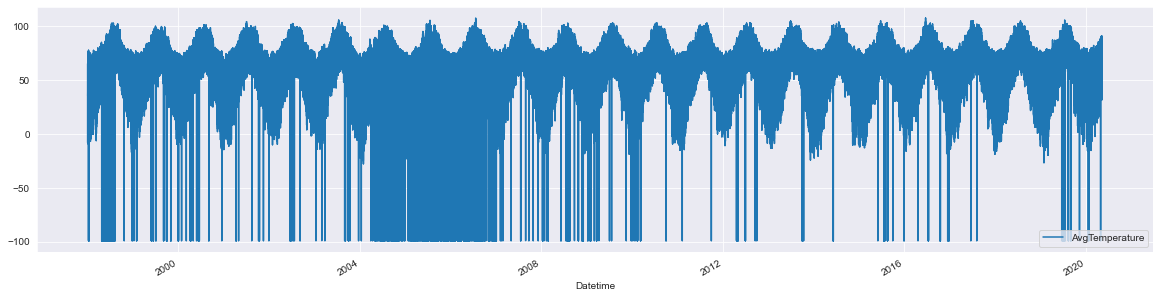

In [17]:
temp.plot(kind='line', x = 'Datetime')
plt.show()

We need to see just how often -99 shows up so that we can decide if we can safely remove it. Given that it takes up less than .33% of our data, we can safely remove it. Within the documentation guide for our dataset it is also noted taht -99 is a flag for missing data. Given that this flag doesn't significantly pop up a lot, we can remove these rows and simply continue to plot our data.

In [18]:
temp.groupby('AvgTemperature').count()

,Region,Country,State,City,Datetime
AvgTemperature,,,,,
-99.0,2975,2975,2975,2975,2975
-27.6,1,1,1,1,1
-26.6,1,1,1,1,1
-26.5,1,1,1,1,1
-24.7,1,1,1,1,1
...,...,...,...,...,...
105.7,1,1,1,1,1
105.8,1,1,1,1,1
107.0,1,1,1,1,1


In [19]:
print(len(temp))

1241610


In [20]:
print(4026/len(temp))

0.003242564090173243


In [21]:
temp = temp[temp.AvgTemperature != -99]
print(temp['AvgTemperature'].describe())

count    1.238635e+06
mean     5.696713e+01
std      1.868943e+01
min     -2.760000e+01
25%      4.340000e+01
50%      5.910000e+01
75%      7.230000e+01
max      1.077000e+02
Name: AvgTemperature, dtype: float64


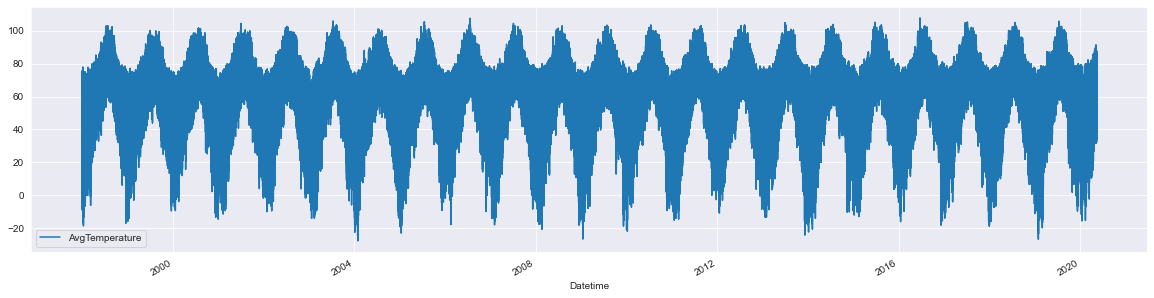

In [22]:
temp.plot(kind='line', x = 'Datetime')
plt.show()

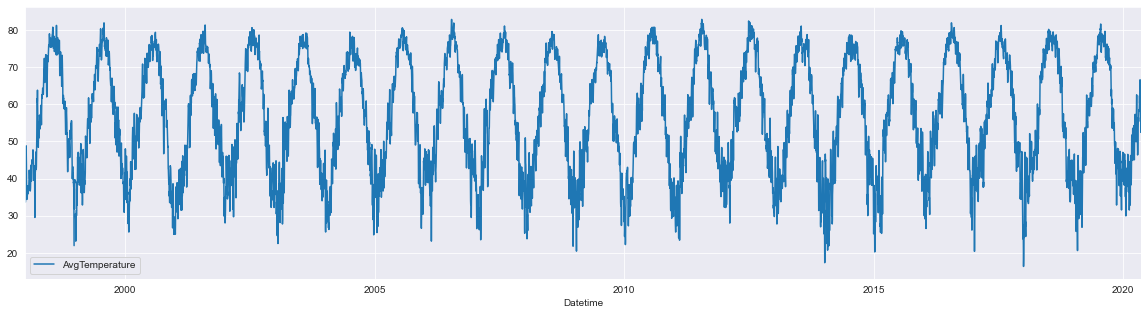

In [23]:
temp_avg = temp.set_index('Datetime').groupby(pd.Grouper(freq='d')).mean()
temp_avg.plot(kind='line')
plt.show()


Before we can add the average temperature to our data on electrical consumption, we need to make sure that it has the correct datetime for each 24 hour period.

In [24]:
new_rows = []
for item in temp_avg.index:
    for i in range(23):
        hour = datetime.timedelta(hours = 1)
        new = item + hour*(i+1)
        new_rows.append([new, ''])
df = pd.DataFrame(new_rows, columns=['Datetime', 'AvgTemperature'])
df = df.set_index('Datetime')
temp_avg = temp_avg.append(df)
temp_avg = temp_avg.sort_index()
temp_avg = temp_avg.replace(r'^\s*$', np.NaN, regex=True)
temp_avg = temp_avg.fillna(method='ffill')
temp_avg.head()

,AvgTemperature
Datetime,
1998-01-01 00:00:00,33.689677
1998-01-01 01:00:00,33.689677
1998-01-01 02:00:00,33.689677
1998-01-01 03:00:00,33.689677
1998-01-01 04:00:00,33.689677


In [29]:
combo_temp = combo.set_index('Datetime')
combo_temp=pd.merge(combo_temp, temp_avg, how='outer', left_index=True, right_index=True)
combo_temp.head()
combo_temp.to_csv('combo_temp.csv')

In [30]:
combo_temp.head()

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJM_Load_MW,PJME_MW,PJMW_MW,Row_Total,Holiday,Holiday_Variable,Weekday,Weekday_num,Long Weekend,AvgTemperature
Datetime,,,,,,,,,,,,,,,,,,,
1998-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.689677
1998-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.689677
1998-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.689677
1998-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.689677
1998-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.689677
